First part : Converting my MobileNet implementation into Nengo (with nengo_dl.Layer) without spiking

In [1]:
%matplotlib inline

!pip install nengo
!pip install nengo-dl

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

import nengo_dl



target_size = 40
num_classes = 10

     |████████████████████████████████| 523 kB 608 kB/s 
     |████████████████████████████████| 283 kB 596 kB/s 
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for nengo-dl: filename=nengo_dl-3.4.1-py3-none-any.whl size=204595 sha256=4ac7e7dbf5ac919c9f57b52f7c34ce0e4c26504eb2f0f5465f06be03f1f8c350
  Stored in directory: /root/.cache/pip/wheels/9e/55/af/7a54eb26bb6cc8d6d64d0d87231f95c98ec71a03444097ba41
Successfully built nengo-dl


First we'll load the training data, the MNIST digits/labels.

11493376/11490434 [==============================] - 0s 0us/step
255.0
0.0


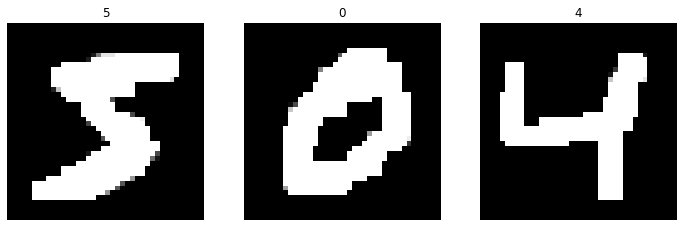

In [2]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()



batchSize = 32

train_images = train_images[:30000]
train_labels = train_labels[:30000]
test_images = test_images[:5000]
test_labels = test_labels[:5000]


#train_images = train_images.astype('float32') * 100
#test_images = test_images.astype('float32') * 100


from sklearn.utils import shuffle
from tensorflow.image import resize#, grayscale_to_rgb

def grayscale_to_rgb(image):
    res = np.zeros((image.shape[0], image.shape[1], image.shape[2], 3))
    res[..., 0] = np.asarray(image)
    res[..., 1] = np.asarray(image)
    res[..., 2] = np.asarray(image)
    return res
    
    
def preprocess_images(x):

    batch = np.asarray(x)
    #batch = batch[..., np.newaxis]
    
           
    batch = grayscale_to_rgb(tf.convert_to_tensor(batch))
    batch = resize(batch, (target_size, target_size))
    batch = np.asarray(batch)
           
    return (batch.astype(np.float32))



train_images = preprocess_images(train_images)

test_images = preprocess_images(test_images)

print(np.max(train_images))
print(np.min(train_images))

#print(train_images[20][20])
# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (target_size, target_size,3)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))

In [3]:
base_model = MobileNet(
        include_top=False,
        dropout = 0.15,
        weights='imagenet',
        input_shape=(target_size, target_size, 3),
        pooling='avg')
for layer in base_model.layers:
    layer.trainable = True  # trainable has to be false in order to freeze the layers

    
layers = base_model.layers
n = len(layers)
k=0

17227776/17225924 [==============================] - 1s 0us/step


Definition of the nengo MobileNet (without spiking)

In [4]:
with nengo.Network(seed=0) as net:
    gain = 10
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([gain])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.RectifiedLinear(amplitude = 0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)
    
    inp = nengo.Node(output=np.ones(target_size* target_size * 3))
    x = nengo_dl.Layer(tf.keras.layers.Reshape((target_size, target_size, 3), input_shape = (target_size * target_size * 3,)))(inp, shape_in = (target_size * target_size * 3,))
    #x = nengo_dl.Layer(neuron_type)(x)
    for i in range(1,n):
        
        if (type(layers[i]) == type(tf.keras.layers.ReLU())):
            x = nengo_dl.Layer(neuron_type)(x)
            
        else :
            x = nengo_dl.Layer(layers[i])(x, shape_in = layers[i].input.type_spec.shape[1:])
                
            if(k==0):
                
                conv0 = x
                k+=1
                
            elif(k==1):
                
                conv1 = x
                k+=1
            
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.5))(x)   
    x = nengo_dl.Layer(tf.keras.layers.Dense(10))(x)
    out = nengo_dl.Layer(tf.keras.layers.Softmax())(x)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [5]:
minibatch_size = 30
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               


In [6]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 20
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))
print(test_images.shape)

(5000, 20, 4800)


In [7]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

/opt/conda/lib/python3.7/site-packages/nengo_dl/simulator.py:1922: UserWarning: Number of elements in input data (5000) is not evenly divisible by Simulator.minibatch_size (30); input data will be truncated.
  f"Number of elements in input data ({data_batch}) is not "


Accuracy before training: 0.10220883786678314


Training of the network

In [8]:
# run training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics=["accuracy"]
)
sim.fit(train_images, {out_p: train_labels}, epochs=5)

# save the parameters to file
sim.save_params("/kaggle/working/spiking_params")

/opt/conda/lib/python3.7/site-packages/nengo_dl/simulator.py:1766: UserWarning: Number of elements (1) in ['str'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  f"Number of elements ({len(data)}) in "


Epoch 1/5
1000/1000 [==============================] - 56s 36ms/step - loss: 1.6699 - out_p_loss: 1.6699 - out_p_accuracy: 0.8152
Epoch 2/5
1000/1000 [==============================] - 36s 36ms/step - loss: 1.5559 - out_p_loss: 1.5559 - out_p_accuracy: 0.9056
Epoch 3/5
1000/1000 [==============================] - 36s 36ms/step - loss: 1.5242 - out_p_loss: 1.5242 - out_p_accuracy: 0.9369
Epoch 4/5
1000/1000 [==============================] - 35s 35ms/step - loss: 1.5183 - out_p_loss: 1.5183 - out_p_accuracy: 0.9429
Epoch 5/5
1000/1000 [==============================] - 36s 37ms/step - loss: 1.5116 - out_p_loss: 1.5116 - out_p_accuracy: 0.9494


Now we can check the classification accuracy again, with the trained parameters.

Test after the training

In [9]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Accuracy after training: 0.9564257264137268


Printing some examples

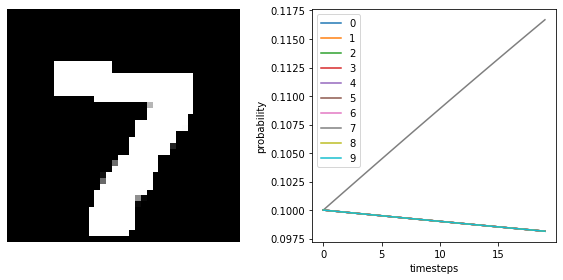

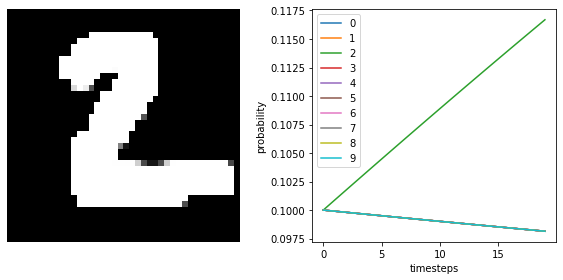

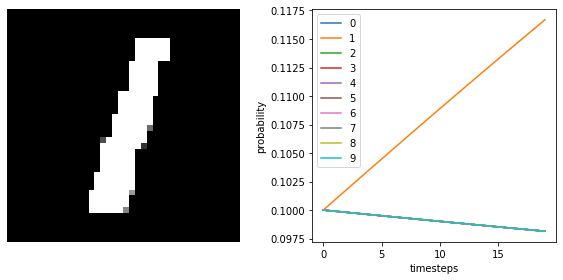

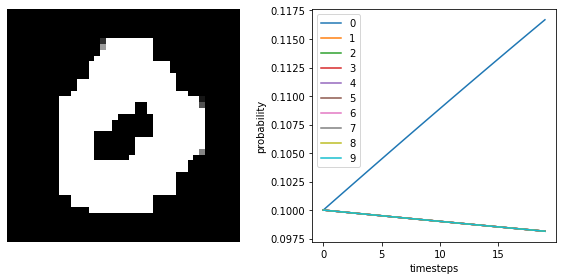

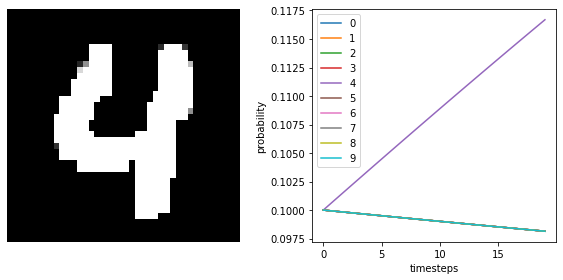

In [10]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((target_size, target_size, 3)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()

In [11]:
sim.close()

Part 2 : Turning the network into a spiking one

In [12]:
base_model2 = MobileNet(
        include_top=False,
        dropout = 0.15,
        weights='imagenet',
        input_shape=(target_size, target_size, 3),
        pooling='avg')
for layer in base_model2.layers:
    layer.trainable = True  # trainable has to be false in order to freeze the layers

    
layers2 = base_model2.layers
n = len(layers2)
k=0

Definition of the network, with a spiking activation this time

Build finished in 0:00:01                                                      
Optimization finished in 0:00:01                                               
Construction finished in 0:00:01                                               
Simulation finished in 0:00:14                                                 
[16.335      23.53210938 26.66214844 21.5446875  21.30148438 17.53890625
 14.57953125 17.288125   19.9771875  12.2571875   8.97328125 16.42675781
 15.18652344  7.98925781  9.71337891 10.78320312 10.69287109 10.28466797
  8.74414062 11.64404297  8.76171875 12.00537109 11.04980469 15.65625
 12.63964844  9.80273438 45.84277344]


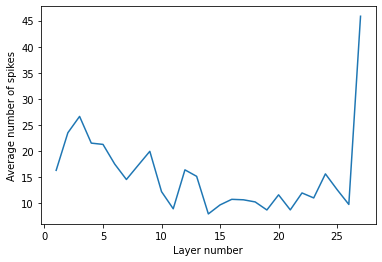

In [13]:
my_spike_probes = []
with nengo.Network(seed=0) as net2:
    gain = 10
    amplitude = 0.1
    synapse = 1*10**(1)
    bias = 0
    
    neuron_type = nengo.SpikingRectifiedLinear(amplitude =1*10**(-2))

    #net2.config[nengo.Ensemble].max_rates = nengo.dists.Choice([1000])
    net2.config[nengo.Ensemble].gain = nengo.dists.Choice([gain])
    net2.config[nengo.Ensemble].bias = nengo.dists.Choice([bias])
    #net2.config[nengo.Ensemble].intercepts = nengo.dists.Choice([-0.1])
    #net2.config[nengo.Ensemble].neuron_type = neuron_type
    net2.config[nengo.Connection].synapse = synapse

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)
    
    inp2 = nengo.Node(output=np.ones(target_size* target_size * 3))

    x2 = nengo_dl.Layer(layers[0])(inp2, shape_in = (target_size, target_size, 3))
    
    for i in range(1,n):
        
        if (type(layers2[i]) == type(tf.keras.layers.ReLU())):
            x2 = nengo_dl.Layer(neuron_type)(x2)#, bias = nengo.dists.Choice([bias]), gain = nengo.dists.Choice([gain]))
            my_spike_probes.append(nengo.Probe(x2))
            
        else :
            x2 = nengo_dl.Layer(layers2[i])(x2, shape_in = layers2[i].input.type_spec.shape[1:])
                
            
    x2 = nengo_dl.Layer(tf.keras.layers.Dropout(0.5))(x2)   
    x2 = nengo_dl.Layer(tf.keras.layers.Dense(10))(x2)
    out2 = nengo_dl.Layer(tf.keras.layers.Softmax())(x2)
    out_p2 = nengo.Probe(out2, label="out_p2")
    out_p_filt2 = nengo.Probe(out2, synapse=0.01, label="out_p_filt2")
    
    
    
with nengo_dl.Simulator(net2) as sim:
    sim.run(1.0) # run for one second
    my_spike_probes = np.asarray(my_spike_probes)
    my_spike_counts = []
    for i in range(len(my_spike_probes)):
        my_spike_counts.append(np.average(np.sum(sim.data[my_spike_probes[i]] > 0, axis=0)))
    my_spike_counts = np.asarray(my_spike_counts)
    print(my_spike_counts)
    
    x = range(1,len(my_spike_counts)+1)
    plt.plot(x, my_spike_counts)
    
    plt.xlabel("Layer number")
    
    plt.ylabel("Average number of spikes")
    
    plt.show()

In [14]:
minibatch_size = 30
sim2 = nengo_dl.Simulator(net2, minibatch_size=minibatch_size)

Build finished in 0:00:01                                                      
Optimization finished in 0:00:01                                               
Construction finished in 0:00:01                                               


In [15]:
# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim2.compile(loss={out_p_filt2: classification_accuracy})
print(
    "Accuracy before training:",
    sim2.evaluate(test_images, {out_p_filt2: test_labels}, verbose=0)["loss"],
)

/opt/conda/lib/python3.7/site-packages/nengo_dl/simulator.py:1922: UserWarning: Number of elements in input data (5000) is not evenly divisible by Simulator.minibatch_size (30); input data will be truncated.
  f"Number of elements in input data ({data_batch}) is not "


Accuracy before training: 0.10220883786678314


We load the parameters saved in the part 1.

In [16]:
sim2.load_params("/kaggle/working/spiking_params")

do_training = True
if do_training:
    #run training
    sim2.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p2: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
        metrics=["accuracy"]
    )
    sim2.fit(train_images, {out_p2: train_labels}, epochs=5)

In [17]:
sim2.compile(loss={out_p_filt2: classification_accuracy})
print(
    "Accuracy after training:")
print(
    sim2.evaluate(test_images, {out_p_filt2: test_labels}, verbose=0)["loss"],
)

Accuracy after training:
0.11465863138437271


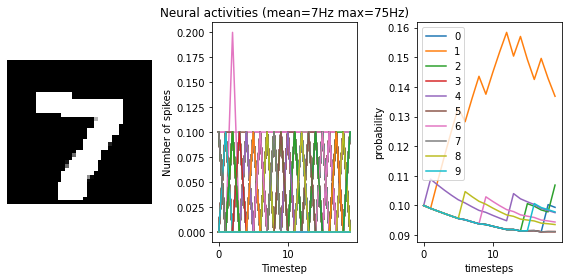

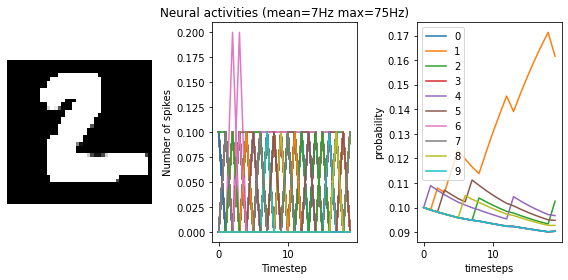

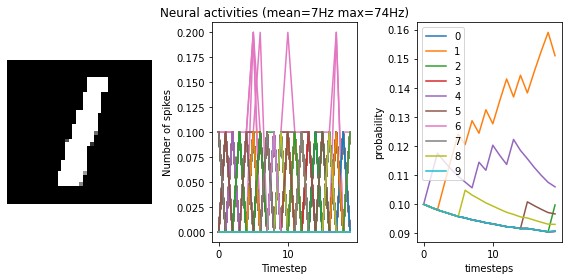

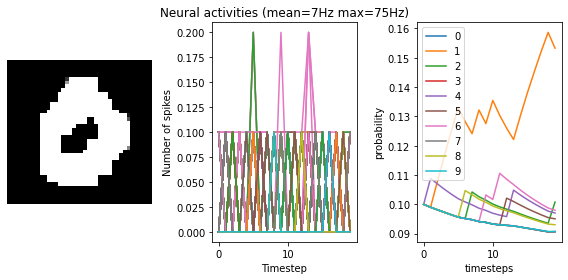

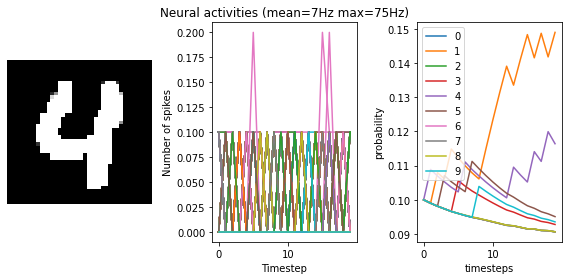

In [18]:
data2 = sim2.predict(test_images[:minibatch_size])
nb_probes = len(my_spike_probes)
index = round(3*nb_probes/4)
my_spike_probe = my_spike_probes[index]
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i, 0].reshape((target_size, target_size, 3)), cmap="gray")
    plt.axis("off")
    
    
    plt.subplot(1, 3, 2)
    sample_neurons = np.linspace(
            0,
            data2[my_spike_probe].shape[-1],
            1000,
            endpoint=False,
            dtype=np.int32,
    )
    scaled_data = data2[my_spike_probe][i, :, sample_neurons].T * gain
    scaled_data *= 0.001
    rates = np.sum(scaled_data, axis=0) / (n_steps * sim2.dt)
    plt.ylabel('Number of spikes')
    plt.xlabel('Timestep')
    plt.title(
            "Neural activities (mean=%dHz max=%dHz)" % (
                rates.mean(), rates.max())
    )
    plt.plot(scaled_data)
    

    plt.subplot(1, 3, 3)
    plt.plot(tf.nn.softmax(data2[out_p_filt2][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()

In [19]:
sim2.close()